In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.morphology import opening, disk
from skimage.transform import resize
sns.set()
from tqdm import tqdm
plt.rcParams["axes.grid"] = False


In [2]:
filename = "../../data/Galaxy10_DECals.h5"

with h5py.File(filename, "r") as f:

    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array
    ra = f['ra'][()]
    dec = f['dec'][()]
    z = f['redshift'][()]
    label = f['ans'][()]
    images = f['images'][()]

Keys: <KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>


In [3]:
print(images.shape)

(17736, 256, 256, 3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


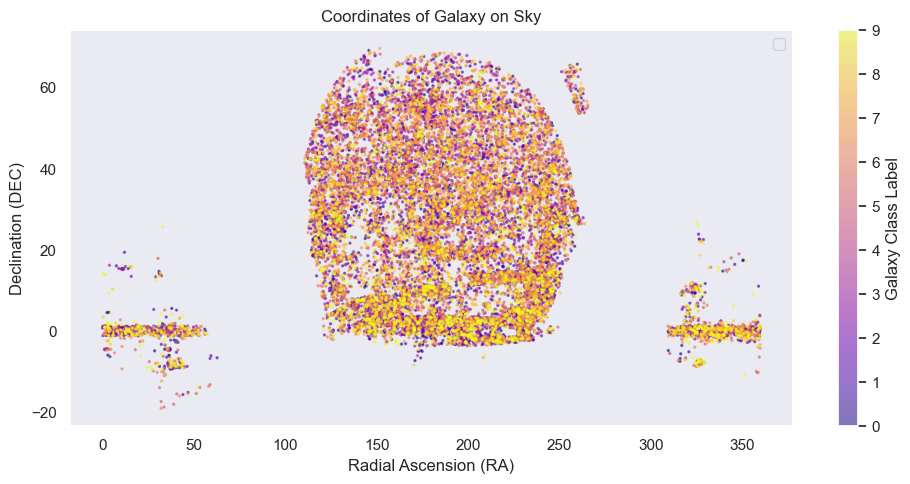

In [4]:
plt.figure(figsize = (10,5))
plt.scatter(ra, dec, c = label, s = 2, cmap = 'plasma', alpha = .5)
cb = plt.colorbar() 
cb.set_label('Galaxy Class Label') 
plt.title("Coordinates of Galaxy on Sky")
plt.xlabel("Radial Ascension (RA)")
plt.ylabel("Declination (DEC)")
plt.legend()
plt.tight_layout()
# plt.savefig('../../plots/RADEC.png', bbox_inches='tight')

Text(0.5, 1.0, 'Galaxy Classes Abundance')

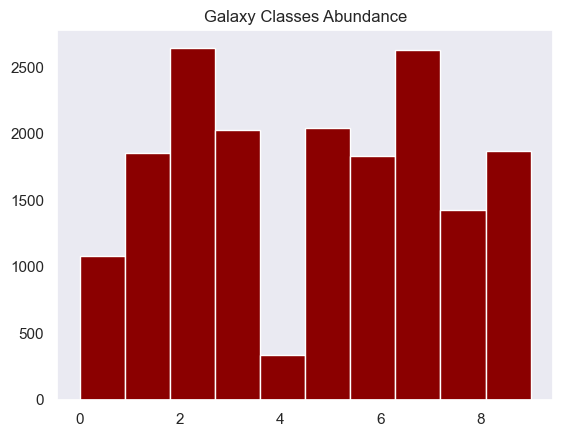

In [5]:
plt.hist(label, color = 'darkred')
plt.title('Galaxy Classes Abundance')
# plt.savefig('../../plots/abundances.png', bbox_inches='tight')

Seems like we are severely lacking labels in 4 (Cigar Shaped Smooth Galaxies). We can omit these

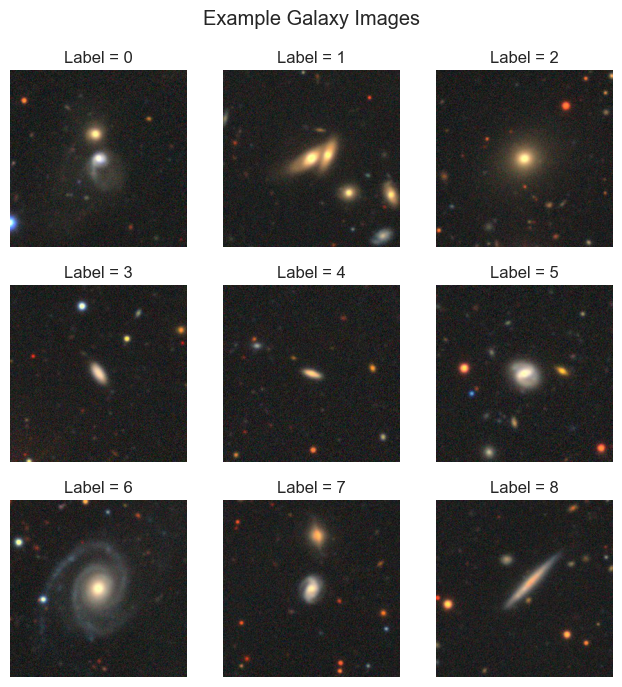

In [6]:
fig = plt.figure(figsize=(7,7))
for i in range(3*3):
    fig.suptitle('Example Galaxy Images')
    ax = fig.add_subplot(3,3, i+1)
    ax.axis('off')
    idx = np.where(label == i)[0][1]
    plt.imshow(images[idx])
    plt.grid(None)
    plt.tight_layout()
    plt.title(f'Label = {label[idx]}')
# plt.savefig('../../plots/galaxies.png')


Some redshift values are NaNs

In [7]:
bad_idxs = np.where(np.isnan(z))[0]
clean_z = np.delete(z, bad_idxs)
clean_label = np.delete(label, bad_idxs)

Text(0.5, 1.0, 'Galaxy Class vs. Redshift')

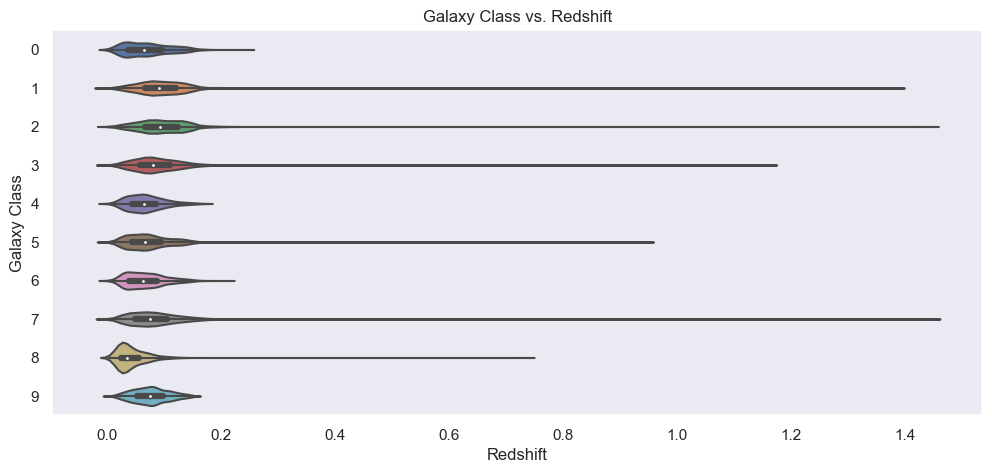

In [8]:
plt.figure(figsize=(12,5))
sns.violinplot(x=clean_z, y=clean_label, orient='h')
plt.xlabel('Redshift')
plt.ylabel('Galaxy Class');
plt.title("Galaxy Class vs. Redshift")
# plt.savefig('../../plots/class_redshift_dependence.png')

From the plot we can see that there are high-redshift outliers for classes 1, 2, 3, 5, 7, and 8. It would be intersting to study validation performances for such high-z galaxies to see if it correlates with performance at all. Despite the outliers, we see that the mean redshift of all galaxy classes is roughly the same value and the share a similar interquartile range (analogous to standard deviation for Gaussian distributions).

We can emphasize the galaxy at the center and discourage information from the background using morphological openings. Below this is applied and a new dataset is created

In [17]:
def morphological_opening(image, element):
    
    opened_r = opening(image[:,:,0], element)
    opened_g = opening(image[:,:,1], element)
    opened_b = opening(image[:,:,2], element)
    
    opened_image = np.dstack((opened_r, opened_g, opened_b))
    
    return opened_image

def resize_image(image):
    
    return resize(image, (224, 224, 3), preserve_range=True).astype(np.uint8)

def add_poisson_noise(image: np.array, snr: float):
    """
    Adds Poisson noise to an image with a specified intensity.

    Args:
        image (numpy.ndarray): The input image is a 256 x 256 x 3 numpy array.
        snr (float): Normalized snr value (between 0 and 1)

    Returns:
        numpy.ndarray: The noisy image as a 256 x 256 x 3 numpy array.
    """
    
    if (snr > 1) or (snr < 0):
        raise ValueError('Unphysical SNR value. Specify 0 < snr < 1')
    
    signal_level = np.mean(image)
    noise_level = signal_level / snr  - signal_level
    noise = np.random.poisson(lam=noise_level, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 255)
    
    return noisy_image

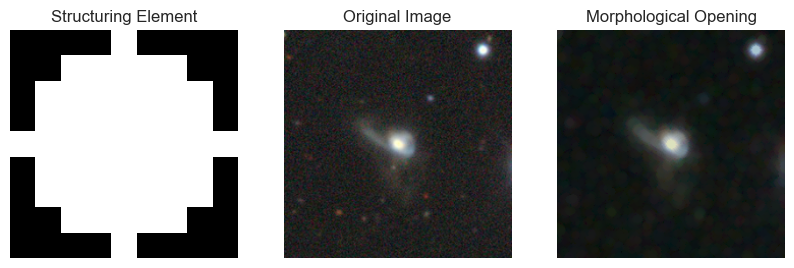

In [13]:
idx = np.where(label == 0)[0][2]
element = disk(4) ## mo== disk(3), mo2 = disk(4)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.imshow(element, cmap='gray')
ax1.set_title('Structuring Element')
ax1.axis('off'), ax2.axis('off'), ax3.axis('off')
ax2.imshow(resize_image(images[idx]))
ax2.set_title('Original Image')
ax3.imshow(morphological_opening(resize_image(images[idx]), element))
ax3.set_title('Morphological Opening');

In [14]:
def save_in_h5py(f, images, labels):
    dataset = f.create_dataset(
        "images", np.shape(images), data=images, compression='gzip', chunks=True)
    meta_set = f.create_dataset(
        "labels", np.shape(labels), data=labels,  compression='gzip', chunks=True)

In [15]:
opened_images = []
for image in tqdm(images):
    opened_image = morphological_opening(resize_image(image), element=disk(4))
    opened_images.append(opened_image)

100%|██████████| 17736/17736 [06:11<00:00, 47.80it/s]


In [16]:
opened_images = np.asarray(opened_images)
f = h5py.File('../../data/Galaxy10_DECals_mo2.h5','w')
save_in_h5py(f, opened_images, label)
f.close()

In [10]:
import h5py

class OnePixelAttack:
    
    def __init__(self, path):
        self.path = path
        with h5py.File(path, "r") as f:
            self.imgs = f['images'][()]
            self.labels = f['labels'][()]
            self.pred_labels = f['pred_labels'][()]
            self.indices = f['indices'][()]
            self.iters = f['iterations'][()]

    def get_image(self):
        return np.array(self.imgs)
    
    def get_label(self):
        return np.array(self.labels)
    
    def get_pred_label(self):
        return np.array(self.pred_labels)
    
    def get_img_idx(self):
        return np.array(self.indices)
    
    def get_iter(self):
        return np.array(self.iters)
    
    def __len__(self):
        return len(self.labels)

In [11]:
C1 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_C1.h5')
C2 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_C2.h5')
C4 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_C4.h5')
C8 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_C8.h5')
C16 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_C16.h5')
D1 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_D1.h5')
D2 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_D2.h5')
D4 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_D4.h5')
D8 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_D8.h5')
# D16 = OnePixelAttack('../../data/new_icml/onepixel_attack_results_D16.h5')
CNN = OnePixelAttack('../../data/new_icml/onepixel_attack_results_CNN.h5')



# filename = "../../data/new_icml/onepixel_attack_results_C4.h5"
# import h5py
# with h5py.File(filename, "r") as f:

#     print("Keys: %s" % f.keys())
#     a_group_key = list(f.keys())[0]
#     data = list(f[a_group_key])
#     data = list(f[a_group_key])
#     # preferred methods to get dataset values:
#     ds_obj = f[a_group_key]      # returns as a h5py dataset object
#     ds_arr = f[a_group_key][()]  # returns as a numpy array
#     imgs = f['images'][()]
#     labels = f['labels'][()]
#     pred_labels = f['pred_labels'][()]
#     indices = f['indices'][()]
#     iters = f['iterations'][()]

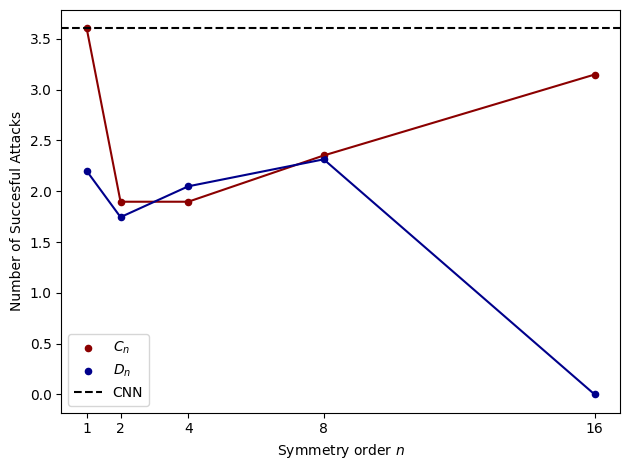

In [12]:
N_vals = [1, 2, 4, 8, 16]
C_vals = [C1, C2, C4, C8, C16]
D_vals = [D1, D2, D4, D8]

C_len_vals = [(len(val) / 2636)*100 for val in C_vals]
D_len_vals = [(len(val) / 2636)*100 for val in D_vals]
D_len_vals.append(0)

plt.scatter(N_vals, C_len_vals, label='$C_n$', s = 20, color = 'darkred')
plt.scatter(N_vals, D_len_vals, label='$D_n$', s = 20, color = 'darkblue')
plt.plot(N_vals, C_len_vals, color = 'darkred')
plt.plot(N_vals, D_len_vals, color = 'darkblue')
plt.axhline(y=((len(CNN) / 2636)*100), color='black', linestyle='--', label='CNN')
plt.xticks(N_vals)
plt.ylabel('Number of Succesful Attacks')
plt.xlabel('Symmetry order $n$')
plt.legend()
plt.tight_layout()

In [39]:
print(len(imgs), len(labels), len(pred_labels), len(indices), len(iters))

150 50 50 50 50


In [35]:
print(labels), print(pred_labels)

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 8 8 8 9 9 9 9 9 9 9 9 9 9]
[7 7 7 3 5 7 5 5 7 3 7 3 3 7 5 6 1 3 7 7 1 6 0 6 3 0 7 6 5 0 7 0 1 1 0 6 1
 0 9 1 9 9 3 0 9 7 1 7 0 1 7 8 7 7 0 6 9 7 7 7 5 7 2 0 7 7 0 5 5 6 5 5 3 5
 5 6 5 6 0 5 0 3 7 9 9 1 8 8 4 8 1 4 8 3 1]


(None, None)

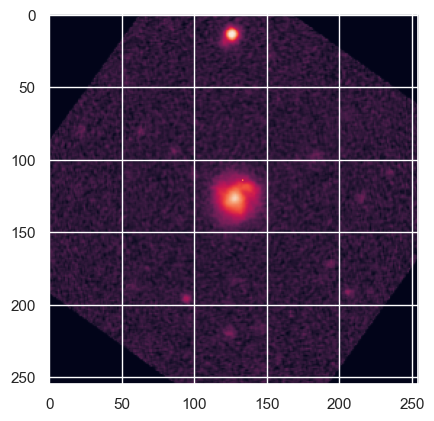

In [26]:
plt.imshow(imgs[97])

Text(0.5, 1.0, 'One Pixel Attack on C2, 46 Misclassified Galaxies')

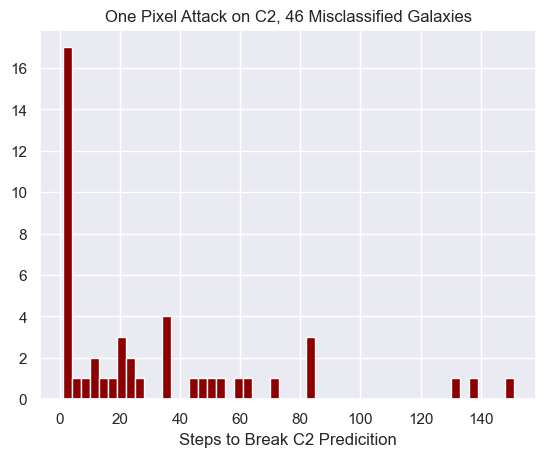

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.hist(iters, bins = 50, color = 'darkred')
plt.xlabel('Steps to Break C2 Predicition')
plt.title(f"One Pixel Attack on C2, {len(iters)} Misclassified Galaxies")
# plt.savefig('../../plots/C2_onepixel.png', bbox_inches='tight')
# plt.xscale('log')

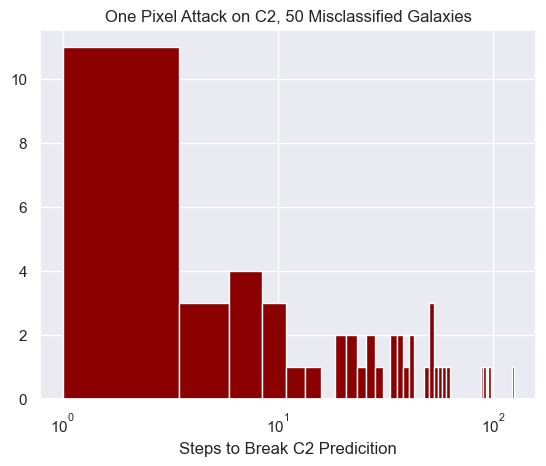

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.hist(iters, bins = 50, color = 'darkred')
plt.xlabel('Steps to Break C2 Predicition')
plt.title(f"One Pixel Attack on C2, {len(iters)} Misclassified Galaxies")
# plt.savefig('../../plots/C2_onepixel.png', bbox_inches='tight')
plt.xscale('log')

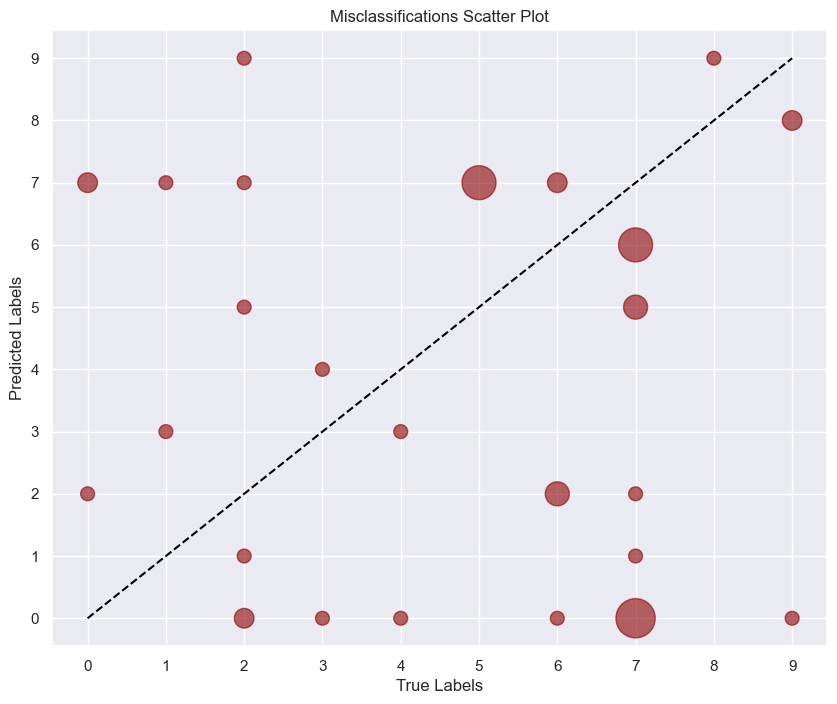

In [11]:
# Create confusion matrix
import numpy as np
confusion_matrix = np.zeros((11,11), dtype=int)
for true, pred in zip(labels, pred_labels):
    confusion_matrix[true, pred] += 1

# Create scatter plot
x = []
y = []
sizes = []

for i in range(11):
    for j in range(11):
        if i != j and confusion_matrix[i,j] > 0:  # Only considering misclassifications
            x.append(i)
            y.append(j)
            sizes.append(100 * confusion_matrix[i,j])  # Adjust the size multiplier (100 here) as needed

plt.figure(figsize=(10,8))
plt.scatter(x, y, s=sizes, alpha=0.6, color = 'darkred')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Misclassifications Scatter Plot')
plt.plot(np.arange(0, 10, 1), np.arange(0, 10, 1), color='black', linestyle='--')
plt.xticks(np.arange(0,10))
plt.yticks(np.arange(0,10))
plt.grid(True)
plt.show()
